## Imports

In [1]:
print(4)

4


In [2]:
import torch

In [3]:
# !pip install git+https://github.com/openai/CLIP.git
# import clip

import os
# os.chdir('/content')
CODE_DIR = 'encoder4editing'

# !git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
# !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
# !sudo unzip ninja-linux.zip -d /usr/local/bin/
# !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

import torch
from argparse import Namespace
import time
import os
import sys
import math
from torch import optim
import torchvision
from tqdm import tqdm
import numpy as np
from PIL import Image

import clip
from IPython.display import display, clear_output
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(f'/home/ayavasileva/{CODE_DIR}')

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

/home/ayavasileva/.conda/envs/count_metrics/lib/python3.10/site-packages/torch/utils/cpp_extension.py:353: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++ 4.8.5) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 5.0 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 5 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))
/home/ayavasileva/.conda/envs/count_metrics/lib/python3.10/site-packages/torch/utils/cpp_extension.py:353: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [4]:
#install sfe
# %cd /content
# !gdown 1HBwy2-36ZeoXXtnx9X6EKXSZxzcV5S6T
# !unzip /content/sfe-main.zip

In [5]:
# %cd /content/encoder4editing/models/stylegan2
# !gdown 1-CWW53TF6gKdrh2An0n-wKXrYRDfmSTi #меняем файл model.py на файл из sfe, там надо было также заменить 1 импорт
# %cd /content/encoder4editing

In [6]:
# %cd /content/encoder4editing

In [7]:
# class Downloader(object):
#     def __init__(self):
#         current_directory = os.getcwd()
#         self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
#         os.makedirs(self.save_dir, exist_ok=True)

#     def download_file(self, file_id, file_name):
#         file_dst = f'{self.save_dir}/{file_name}'
#         if os.path.exists(file_dst):
#             print(f'{file_name} already exists!')
#             return
#         !gdown --id $file_id -O $file_dst

# downloader = Downloader()

In [8]:
experiment_type = 'ffhq_encode'

# MODEL_PATHS = {
#     "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"}}


# path = MODEL_PATHS[experiment_type]
# downloader.download_file(file_id=path["id"], file_name=path["name"])

In [9]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "/home/ayavasileva/encoder4editing/pretrained_models/e4e_ffhq_encode.pt",
    }
}
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
img_transforms = EXPERIMENT_ARGS['transform']

Change model file

In [10]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: /home/ayavasileva/encoder4editing/pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


In [11]:
# %cd /content
# !git clone https://github.com/orpatashnik/StyleCLIP
# %cd /content/StyleCLIP/models/facial_recognition
# !gdown 1TFk3sDBNMq_kyU1uMBbEJnkY0ioPFugL

In [12]:
os.chdir("/home/ayavasileva/StyleCLIP/models/facial_recognition")

In [13]:
from model_irse import Backbone

In [14]:
# %cd /content/encoder4editing/pretrained_models

In [15]:
# !gdown 1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn

## Templates

In [16]:
imagenet_templates = [
    'a bad photo of a {}.',
#    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


## Losses Init

In [17]:
def zeroshot_classifier(classnames, templates,model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

In [18]:
def GetDt(classnames,model):
    features=zeroshot_classifier(classnames, imagenet_templates,model).t()

    dt=features[1]-features[0]
    print(dt.shape)

    #print(dt.norm())
    dt=dt/dt.norm()
    return dt, features[1]

In [19]:
class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("/home/ayavasileva/ViT-B-32.pt", device="cuda")
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((224, 224))
        self.reg = 0
        # self.dt = 0 #эмбединг для разницы между целевыми текстами храним тут, так как он не меняется
        self.loss = torch.nn.MSELoss()
        self.transform = transforms.Normalize((-1, -1, -1), (2, 2, 2))
        self.transform_clip = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    def forward(self, image1, image2, frozen_features, target_text):

        #dt = GetDt(texts, self.model)

        image2 = torch.clamp(self.transform(image2), 0.0, 1.0)
        image2 = self.transform_clip(self.avg_pool(image2))
        image1 = torch.clamp(self.transform(image1), 0.0, 1.0)
        image1 = self.transform_clip(self.avg_pool(image1))

        logits_per_image_init, logits_per_text_init = self.model(image1, frozen_features)
        logits_per_image, logits_per_text = self.model(image2, frozen_features)

        # print(logits_per_image_init) это чтобы смотреть что как меняется
        # print(logits_per_image)

        lambda_save = 1


        self.reg = lambda_save * self.loss(logits_per_image_init[0], logits_per_image[0])  #чтобы печатать в цикле значение loss
        
        self.sim = (logits_per_image_init[0] - logits_per_image[0]) / 100

        similarity = 1 -  self.model(image2, target_text)[0] / 100 + self.reg  #styleclip orig but mod
        #print("cosine loss", 1 - (self.dt).dot(di))

        return similarity

In [20]:
class IDLoss(torch.nn.Module):
    def __init__(self):
        super(IDLoss, self).__init__()
        print('Loading ResNet ArcFace')
        self.facenet = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
        self.facenet.load_state_dict(torch.load("/home/ayavasileva/encoder4editing/pretrained_models/model_ir_se50.pth"))
        self.pool = torch.nn.AdaptiveAvgPool2d((256, 256))
        self.face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))
        self.facenet.eval()
        self.facenet.cuda()
        self.opts = opts

    def extract_feats(self, x):
        if x.shape[2] != 256:
            x = self.pool(x)
        x = x[:, :, 35:223, 32:220]  # Crop interesting region
        x = self.face_pool(x)
        x_feats = self.facenet(x)
        return x_feats

    def forward(self, y_hat, y):
        n_samples = y.shape[0]
        y_feats = self.extract_feats(y)  # Otherwise use the feature from there
        y_hat_feats = self.extract_feats(y_hat)
        y_feats = y_feats.detach()
        loss = 0
        sim_improvement = 0
        count = 0
        for i in range(n_samples):
            diff_target = y_hat_feats[i].dot(y_feats[i])
            loss += 1 - diff_target
            count += 1

        return loss / count, sim_improvement / count

In [21]:
def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)
    #print(initial_lr * lr_ramp)
    return initial_lr * lr_ramp

In [22]:
id_loss = IDLoss()
clip_loss = CLIPLoss()

Loading ResNet ArcFace


In [23]:
os.chdir("/home/ayavasileva/sfe-main/utils")

In [24]:
from model_utils import get_stylespace_from_w

## Load image

In [25]:
latent_code_init = torch.load("/home/ayavasileva/data/codes/man_blue_eyes_glasses.pt")

In [26]:
# z = torch.randn(1, 512)
# latent_code_init = net.decoder.get_latent(z.to("cuda:0"))
#image, latent_code_init = net.decoder([z.to("cuda:0")], input_is_latent=False, randomize_noise=False, return_latents=True)

In [27]:
initial_s = get_stylespace_from_w(latent_code_init, net.decoder)

In [28]:
with torch.no_grad():
    img_orig, feat = net.decoder(initial_s, is_stylespace=True, randomize_noise=False, return_features=True)

In [29]:
img_orig1 = tensor2im(img_orig[0]).resize((512,512))

7 32

8 64

9 64


In [30]:
feat_8 = feat[9]

In [31]:
feat_8.shape

torch.Size([1, 512, 64, 64])

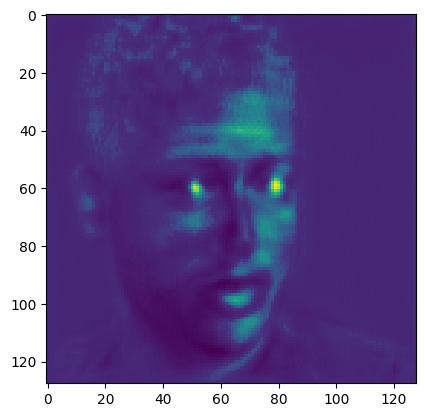

In [32]:
%matplotlib inline
plt.imshow(feat[11][0][110].cpu().numpy(), interpolation='nearest')
plt.show()

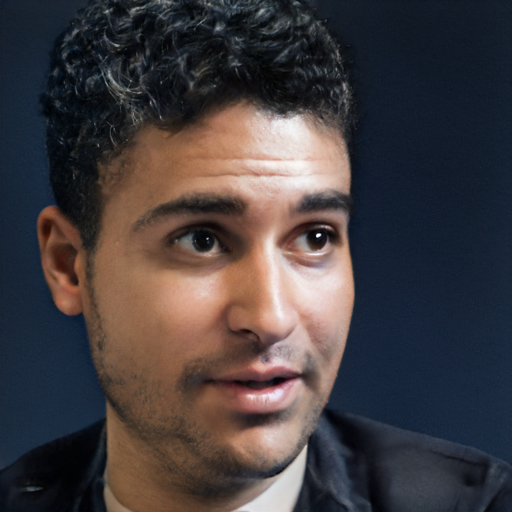

In [33]:
tensor2im(img_orig[0]).resize((512,512))

In [34]:
frozen_texts = ["background", "face with big ears", "face with black hair", "face with double chin", "face with nose", "face with forehead"]
text_inputs =  ["person with blue eyes"]

In [279]:
# latent = latent_code_init.detach().clone()  #w case
# latent.requires_grad = True

## Optimization


In [280]:
latent_s_layers_init = initial_s[0] #s_layers
latent_s_rgb_init = initial_s[1]  #s_rgb

In [281]:
latent_s_layers = []
for layer in latent_s_layers_init:
    latent_s_layers.append(layer.detach().clone()) #каждый тензор из списка отдельно
#     # latent_s_layers[-1].requires_grad = True

In [282]:
latent_rgb_layers = []
for layer in latent_s_rgb_init:
    latent_rgb_layers.append(layer.detach().clone())
#     #latent_rgb_layers[-1].requires_grad = True

In [283]:
# feat_new = []
# for i, featt in enumerate(feat):
#     feat_new.append(featt.detach().clone()) #каждый тензор из списка отдельно
#     if i > 5 and i < 8:
#         feat_new[-1].requires_grad = True

In [284]:
latent_s = (latent_s_layers, latent_rgb_layers)

In [285]:
feat_8_new = feat_8.detach().clone()
feat_8_new.requires_grad = True

In [286]:
#optimizer = optim.Adam(latent_s_layers , lr=0.02)
#optimizer = optim.Adam([feat_8_new], lr=0.005)
optimizer = optim.Adam([feat_8_new], lr=0.01)
#optimizer = optim.Adam([latent] , lr=0.02)
#net.eval()

In [287]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

In [288]:
steps = 1000
start_lr = 0.007
lambda_reg = 15

In [289]:
losses_mod = []
imgs_mod = []
c_losses_mod = []
i_losses_mod = []
l2_losses = []

In [290]:
frozen_features = torch.cat([clip.tokenize(frozen_texts)]).cuda()
target_text = clip.tokenize(text_inputs[0]).cuda()
#clip_loss.get_initial_logits(img_orig, frozen_features)

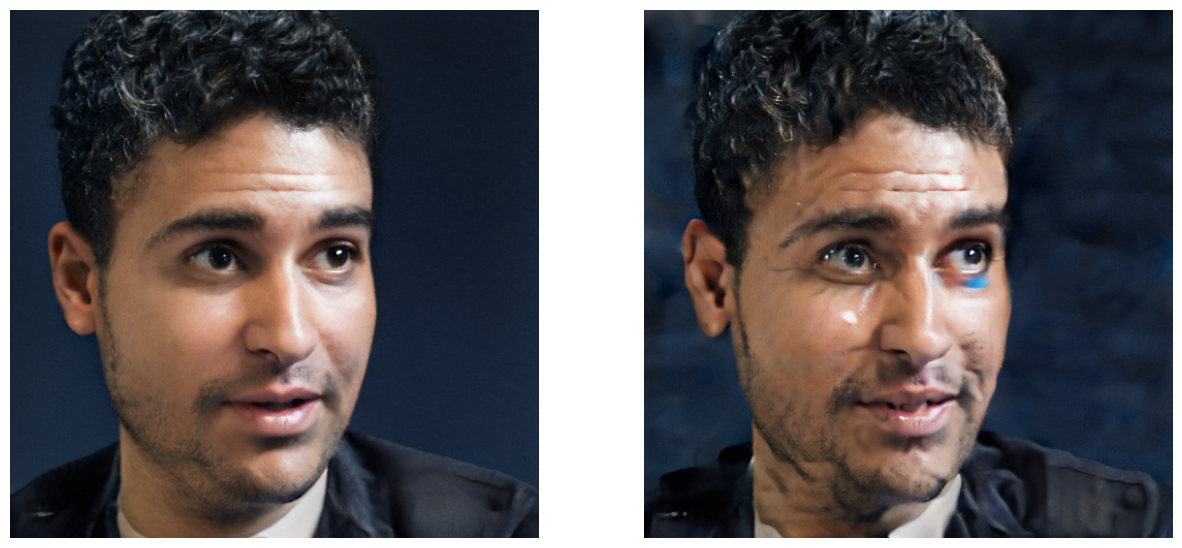

100%|█████████▉| 997/1000 [04:59<00:01,  2.61it/s]

Losses: 
0.524169921875
0.000244140625
0.5244140625
tensor([-0.0002, -0.0002, -0.0002,  0.0002, -0.0002, -0.0002], device='cuda:0',
       dtype=torch.float16, grad_fn=<DivBackward0>)
0.000972747802734375
---------------
4.420651878938864e-06


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


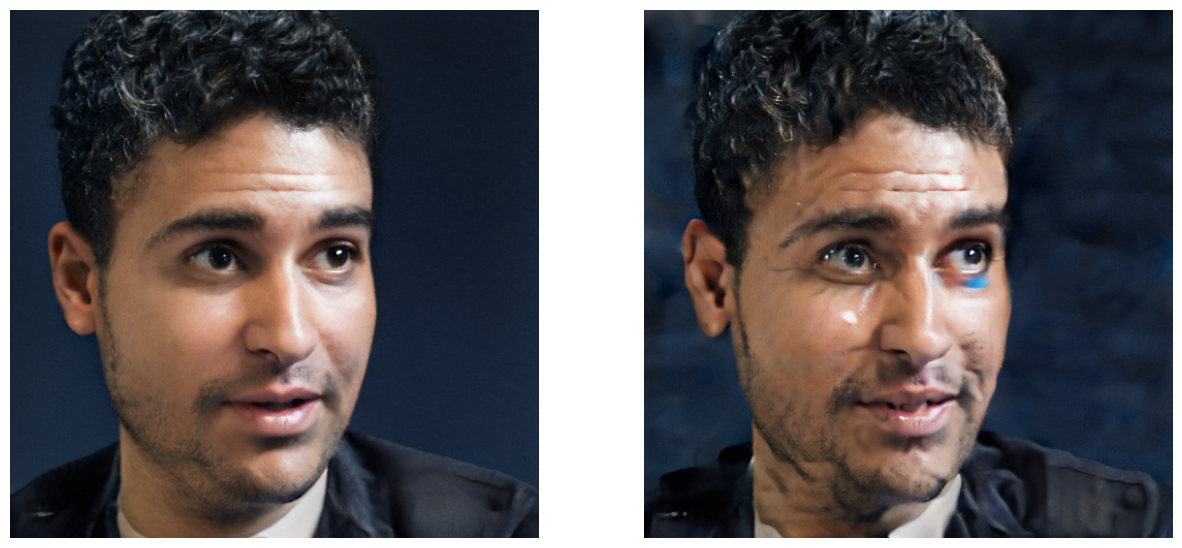

In [291]:
for i in tqdm(range(steps)):
    t = (i) / (steps)
    lr = get_lr(t, start_lr)
    optimizer.param_groups[0]["lr"] = lr

    #img_gen, _ = net.decoder(latent_s, is_stylespace=True, randomize_noise=False, features_in=feat_new)
    img_gen, _ = net.decoder(latent_s, is_stylespace=True, randomize_noise=False, inserted_feature=feat_8_new)
    #img_gen, _ = net.decoder(initial_s, is_stylespace=True, randomize_noise=False, features_in = feat_8_new)

    c_loss = clip_loss(img_orig, img_gen,frozen_features, target_text)

    if lambda_reg > 0:
        i_loss = id_loss(img_gen, img_orig)[0]
    else:
        i_loss = 0
    # lambda_l2  = 0.001
    # l2_loss = torch.norm(feat_8_new[0] - feat_8[0], p=2)

    loss = c_loss + lambda_reg * i_loss
    #+

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    losses_mod.append(loss.item())
    c_losses_mod.append(c_loss.item() -  clip_loss.reg.item())
    # l2_losses.append(lambda_l2 * l2_loss)
    # i_losses_mod.append(lambda_reg * i_loss.item())
    if i % 5 == 1:
        if i != 1:
            plt.close()
        imgs_mod.append(img_gen[0])
        clear_output(wait=True)
        plt.figure(figsize=(15, 10))
        plt.subplot(1,2, 1)
        plt.imshow(img_orig1)
        plt.axis('off')
        plt.subplot(1,2, 2)
        im = tensor2im(img_gen[0]).resize((512,512))
        plt.imshow(im)
        plt.axis('off')
        display(plt.gcf())

        print("Losses: ")
        print(c_loss.item() - clip_loss.reg.item())
        print(clip_loss.reg.item())
        print(c_loss.item())
        print(clip_loss.sim)
        # print(lambda_l2 * l2_loss)
        print(lambda_reg * i_loss.item())
        # print(scheduler.get_last_lr())
        print("---------------")
        print(lr)

In [277]:
torch.sort(torch.linalg.norm(torch.abs(feat_8_new - feat_8) ,1, dim=(2,3)))

torch.return_types.sort(
values=tensor([[3.5465, 3.5593, 3.5715, 3.6075, 3.6483, 3.7050, 3.7241, 3.7332, 3.7404,
         3.7451, 3.7460, 3.7579, 3.7623, 3.7683, 3.7717, 3.7832, 3.8019, 3.8230,
         3.8359, 3.8499, 3.8560, 3.8696, 3.8716, 3.8725, 3.8747, 3.8815, 3.8963,
         3.9006, 3.9101, 3.9204, 3.9222, 3.9391, 3.9458, 3.9602, 3.9695, 3.9701,
         3.9748, 3.9783, 3.9911, 3.9965, 3.9965, 4.0014, 4.0044, 4.0060, 4.0131,
         4.0194, 4.0293, 4.0302, 4.0316, 4.0352, 4.0427, 4.0430, 4.0458, 4.0500,
         4.0503, 4.0580, 4.0602, 4.0607, 4.0625, 4.0639, 4.0660, 4.0752, 4.0761,
         4.0763, 4.0781, 4.0800, 4.0820, 4.0865, 4.0932, 4.1005, 4.1022, 4.1077,
         4.1120, 4.1141, 4.1155, 4.1160, 4.1176, 4.1196, 4.1203, 4.1204, 4.1226,
         4.1241, 4.1282, 4.1314, 4.1319, 4.1385, 4.1385, 4.1406, 4.1458, 4.1472,
         4.1501, 4.1515, 4.1602, 4.1657, 4.1698, 4.1703, 4.1712, 4.1719, 4.1751,
         4.1752, 4.1763, 4.1812, 4.1841, 4.1890, 4.1896, 4.1907, 4.1923, 4.19

In [241]:
feat = [feat_8, feat_8_new - feat_8, feat_8_new]
txt = ["Было", "Разница", "Стало"]

In [242]:
torch.norm(feat[2][0, 380] - feat[0][0, 207])

tensor(61.9949, device='cuda:0', grad_fn=<CopyBackwards>)

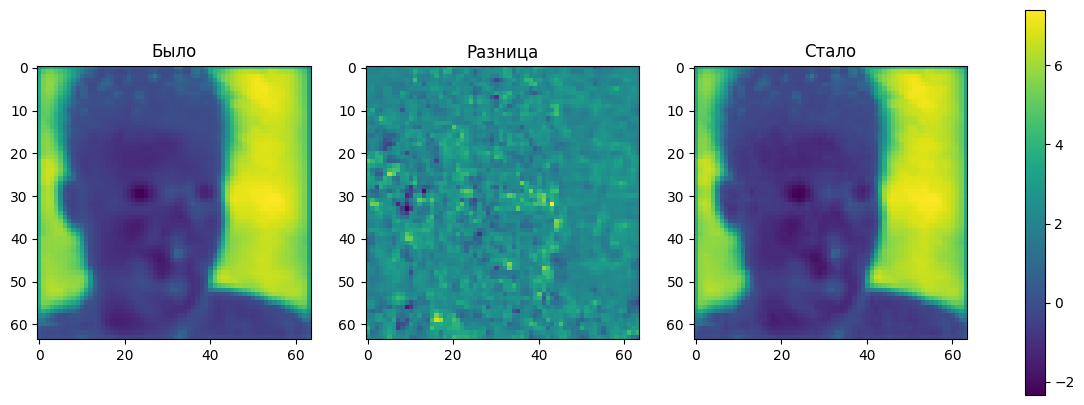

In [247]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))


for i in range(3):
    im = axs[i].imshow(feat[i][0, 357].detach().cpu().numpy(), interpolation='nearest')
    axs[i].set_title(txt[i])


fig.colorbar(im, ax=axs.ravel().tolist())


plt.show()


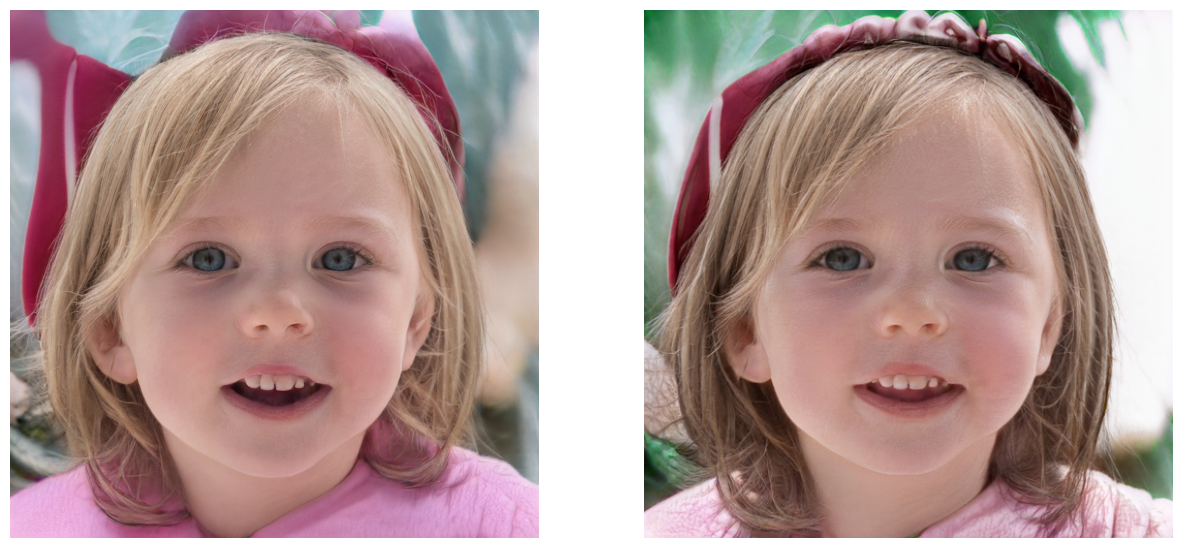

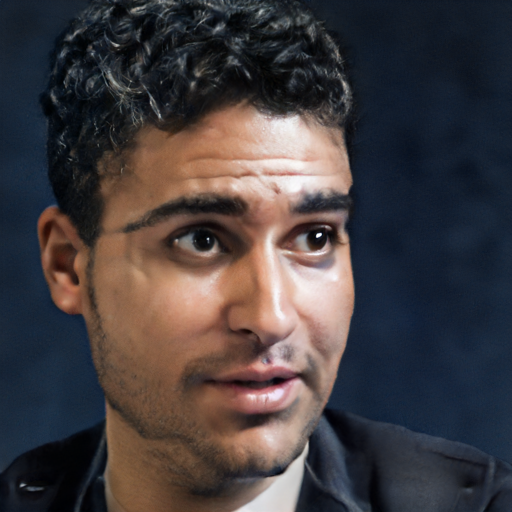

In [151]:
tensor2im(imgs_mod[-5]).resize((512,512))

## Visualizations

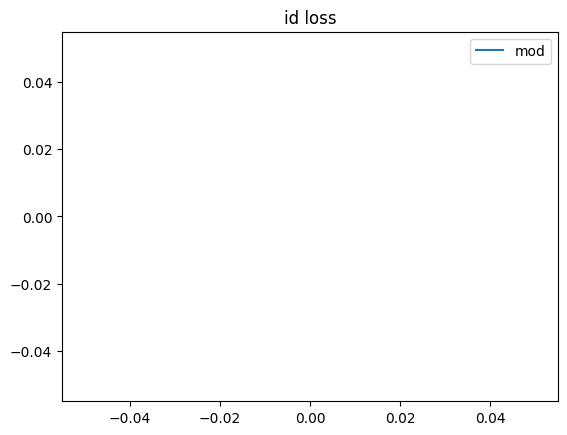

In [205]:
#plt.plot(i_losses, label='orig')
plt.plot(i_losses_mod, label='mod')
plt.title("id loss")
plt.legend()
plt.show()

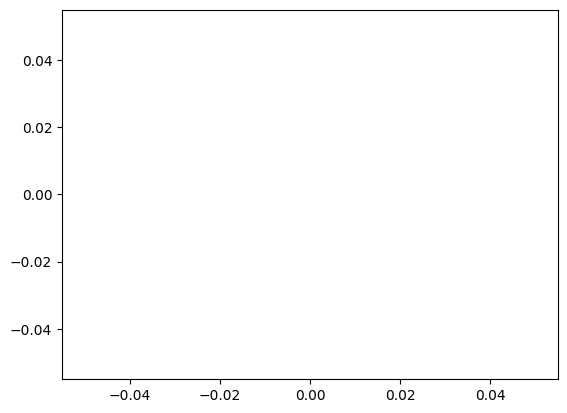

In [206]:
plt.plot(l2_losses, label='clip')

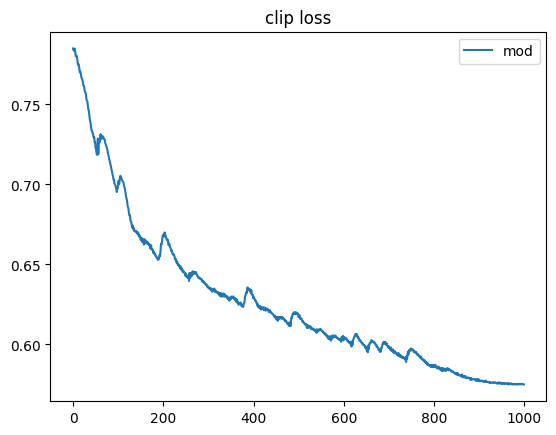

In [183]:
#plt.plot(c_losses, label='orig')
plt.plot(c_losses_mod, label='mod')
plt.title("clip loss")
plt.legend()
plt.show()

In [ ]:
# for img in imgs:
#     clear_output(wait=True)
#     im = tensor2im(img).resize((512,a512))
#     display(im)
#     time.sleep(1)

In [ ]:
plt.figure(figsize=(15, 10)) # Adjust the figure size as needed
plt.subplot(1,3, 1)
im1 = tensor2im(imgs[5])
plt.imshow(im1)
plt.axis('off') # Turn off axis for cleaner display
plt.subplot(1, 3, 2)
plt.imshow(tensor2im(img_orig[0]))
plt.axis('off')
plt.subplot(1, 3, 3)
im2 = tensor2im(imgs_mod[5])
plt.imshow(im2)
plt.title("step 51")
plt.axis('off')
plt.show()

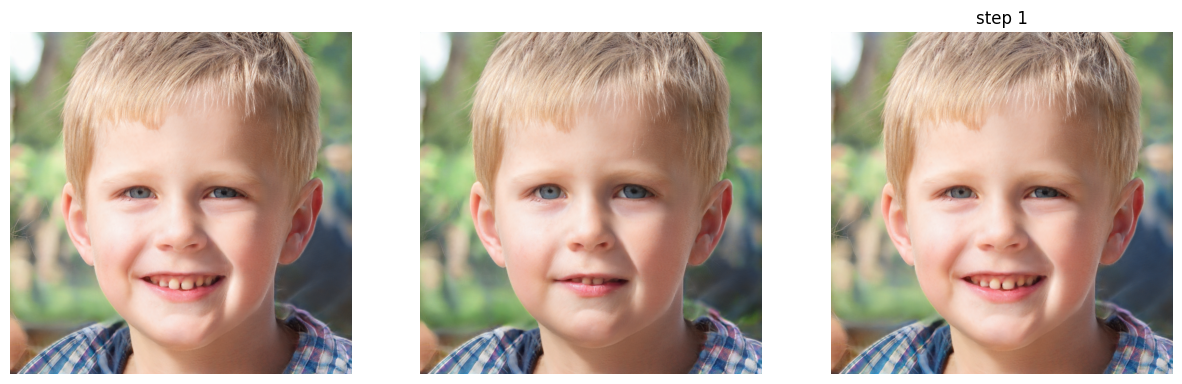

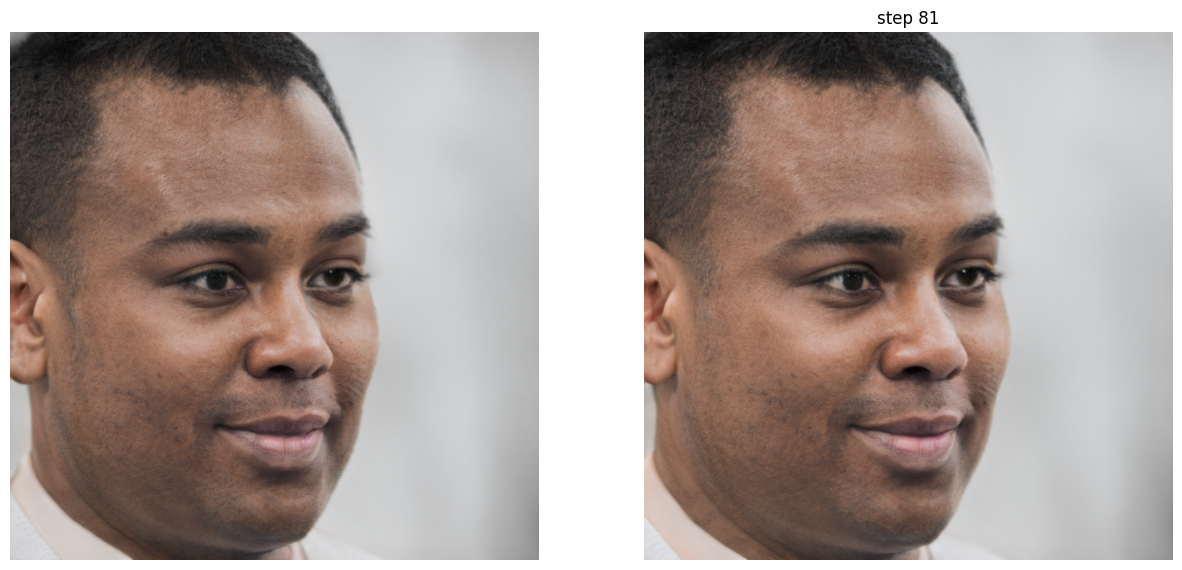

In [ ]:
plt.figure(figsize=(15, 10)) # Adjust the figure size as needed
# plt.subplot(1,3, 1)
# im1 = tensor2im(imgs[5])
# plt.imshow(im1)
# plt.axis('off') # Turn off axis for cleaner display
plt.subplot(1, 2, 1)
plt.imshow(tensor2im(img_orig[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
im2 = tensor2im(imgs_mod[8])
plt.imshow(im2)
plt.title("step 81")
plt.axis('off')
plt.show()